# ECON 227 - How Do Large Language Models Predict?

prAxIs UBC Team <br> Krishaant Pathmananathan, Yash Mali, Kaiyan Zhang  
2025-08-26

This notebook explores how large language models (LLMs) work by linking
their probability-based predictions to real-world applications. We start
with the basics of next-word prediction, then extend the idea to
forecasting stock prices using news sentiment.

### Prerequisite

Before you start, make sure you have the required libraries installed,
if not, **uncomment the lines below (i.e. remove the #) and run the cell
to install them**:

In [1]:
# # Core packages
# !pip install \
#     yfinance \
#     finvizfinance \
#     transformers \
#     pandas \
#     numpy \
#     statsmodels \
#     holidays \
#     plotly \
#     ipywidgets \
#     scikit-learn
# !pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cpu --quiet

**Important:** Run this cell to load the libraries we need for running
this notebook.

In [2]:
# load libraries we need to run this notebook
import os
import glob
import warnings
from datetime import datetime, timedelta
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from finvizfinance.quote import finvizfinance
from transformers import pipeline
from statsmodels.tsa.statespace.sarimax import SARIMAX
import holidays
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics import mean_squared_error, mean_absolute_error
from forecast_plot import create_plot

### 1 Introduction: Distribution of LLM Predictions

Large language models like ChatGPT do something that seems very simple:
**Next word prediction**.

What does that mean? It means that given a sequence of words, the model
predicts the next word in the sequence. For example, if the input is
“The cat sat on the”, the model might predict “mat” as the next word.

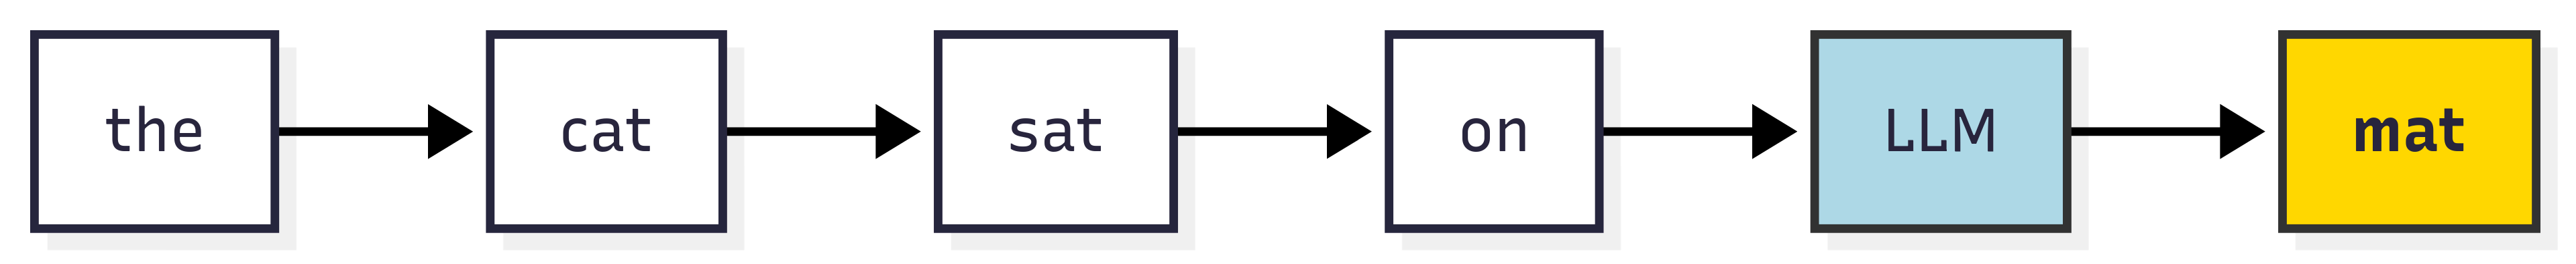

We saw an example of predicting just one word. These models predict only
one word at a time, but they can do this for very long sequences of
words.

For example: “bob went to the store” to buy some milk.

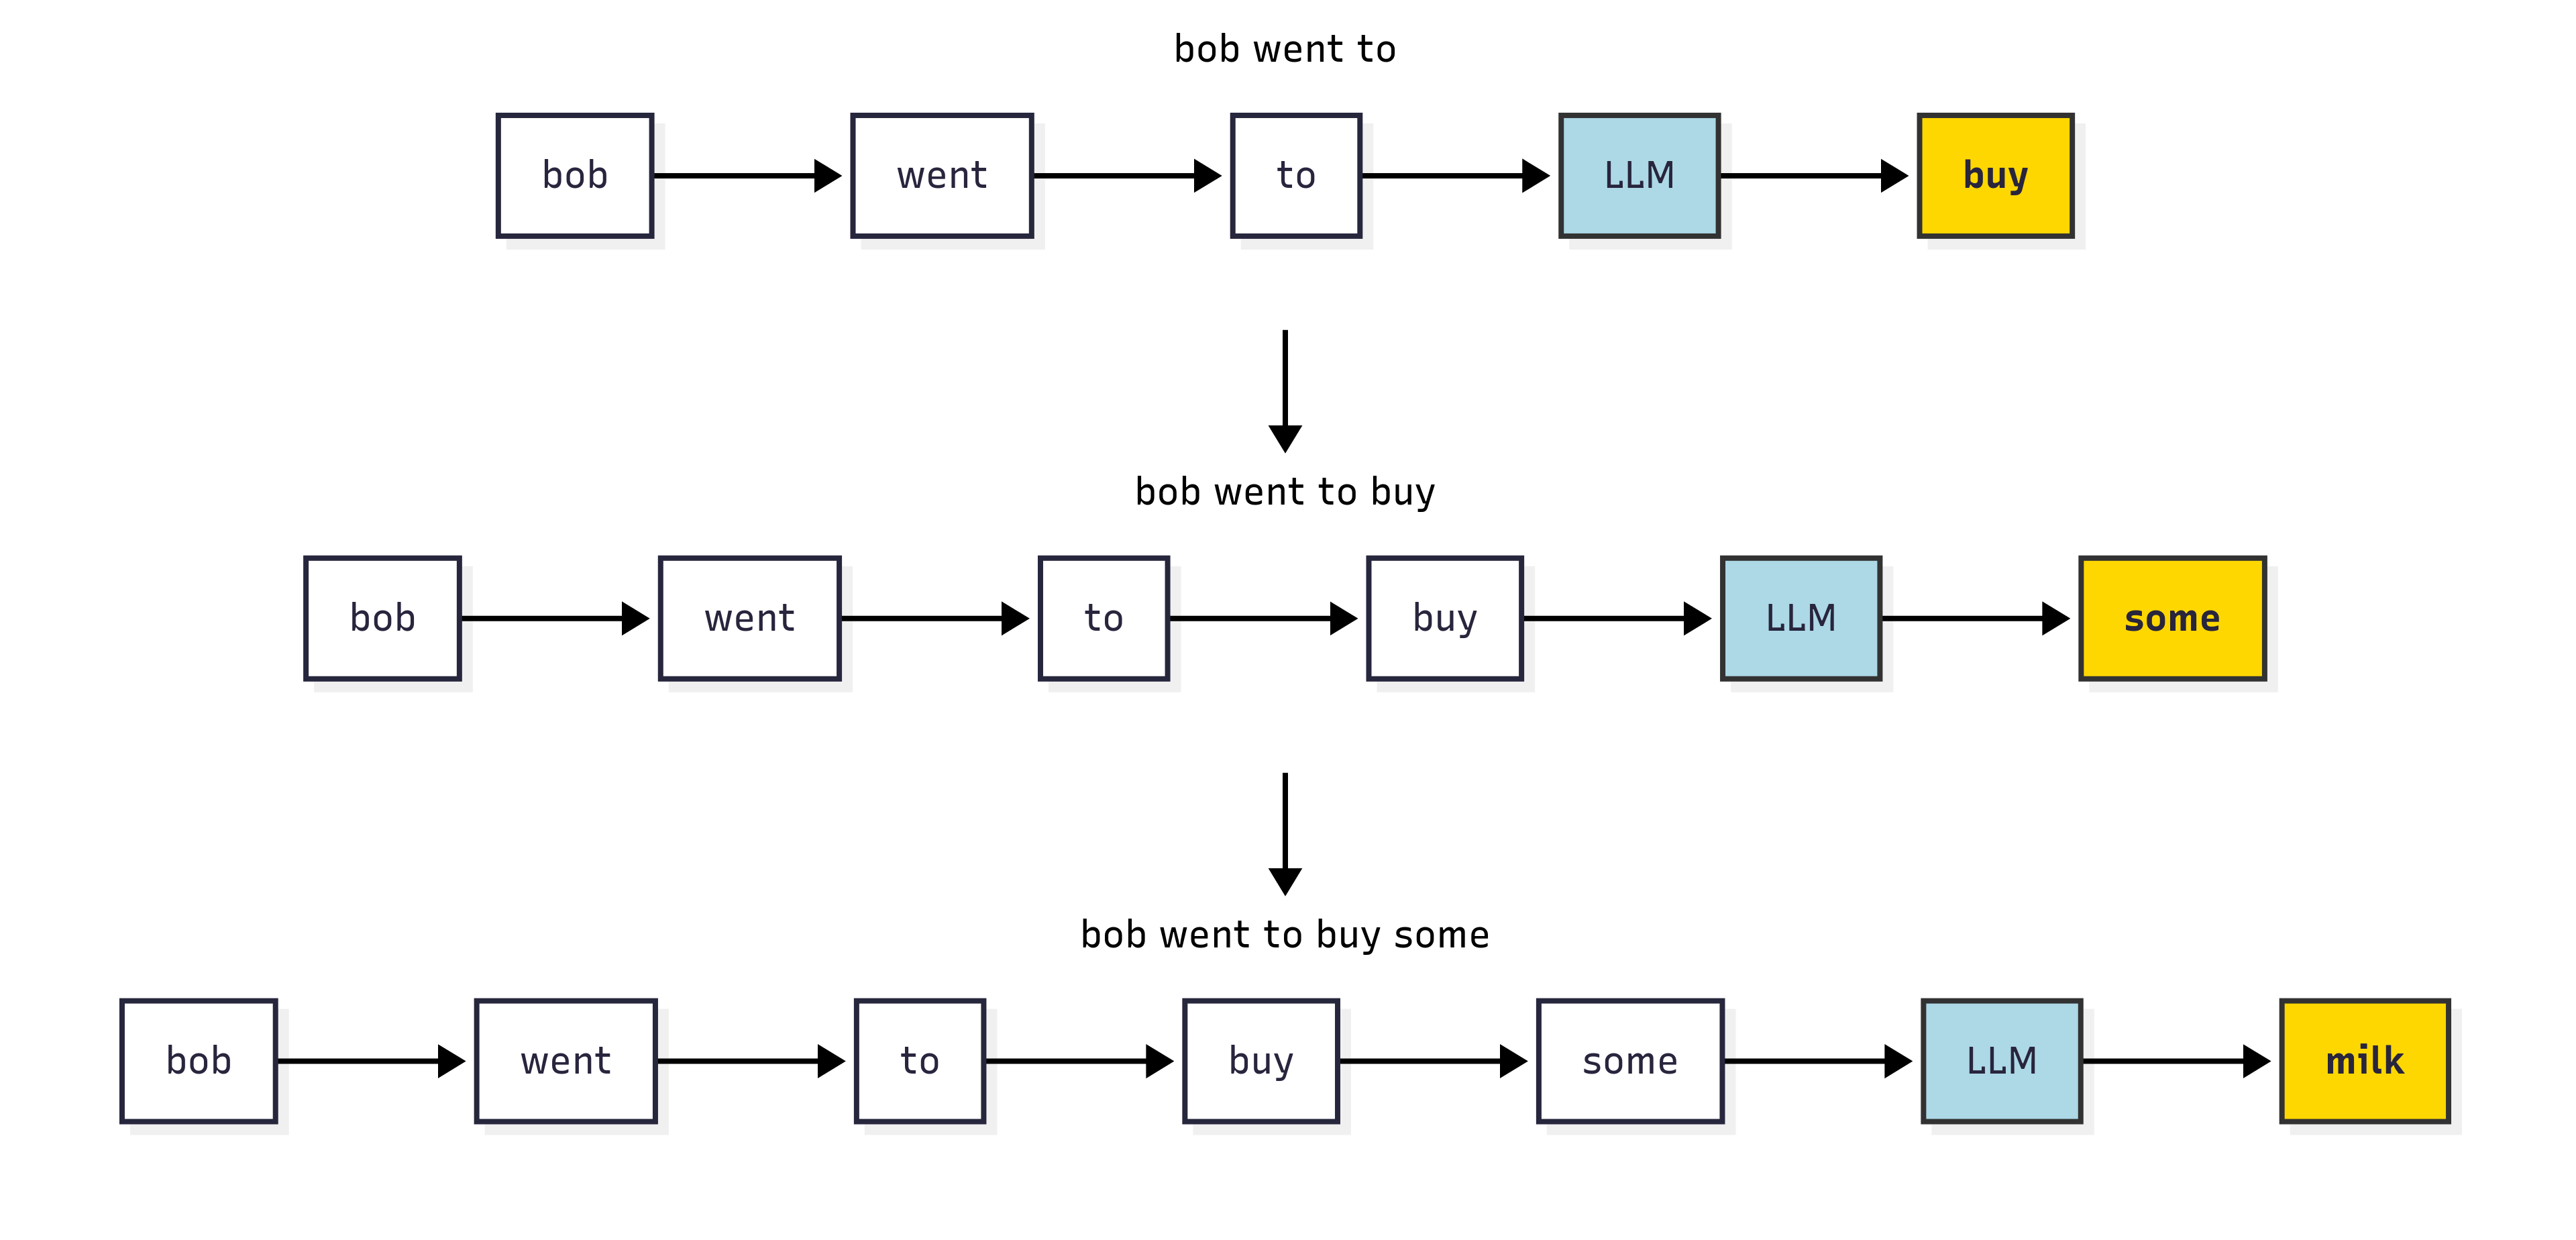

Here, let’s say we will output a total of $T$ words to form a sentence,
$w_1, w_2, \ldots, w_{t-1}, w_t$ are the words in the sentence and the
subscript $t$ means the word is at the position $t$.

What the model does is learning the **probability distribution** of the
next word given the previous words. It is to create a list of
non-negative numbers, one for each possible next word, that add up to 1.

Given the previous words $w_1, w_2, \ldots, w_{t-1}$, the probability of
predicting the next word $w_{t}$ is called **conditional probability**:
it essentially measures for all words in the vocabulary, “the
probability of the next word being this word, based on what was already
said”.

Mathematically, this is defined as below:

$$
P(w_t \mid w_1, w_2, \ldots, w_{t-1}) = \frac{P(w_1, w_2, \ldots, w_{t-1}, w_t)}{P(w_1, w_2, \ldots, w_{t-1})}
$$

LLMs can approximate this probability by learning from training
datasets. Then, when they make predictions, they will select the word at
position $t$ as the word with the maximum
$P(w_t \mid w_1, w_2, \ldots, w_{t-1})$.

With **chain rule**, the model can also use the conditionals for every
position to calculate the probability of a whole sentence:

$$
P(w_1, w_2, \ldots, w_T) = \prod_{t=1}^T P(w_t\mid w_1, \ldots w_{t-1})
$$

These models give a probability distribution over the entire vocabulary
(all the words the model was trained on). We can then pick the word with
the highest probability as the next word or we can sample from this
distribution to get more varied (creative) outputs.

Let’s look at an example of how this works in practice:

In [3]:
warnings.filterwarnings("ignore")

# Example vocabulary
vocab = ['buy', 'some', 'milk', 'along', 'the', 'way']

# Probabilities at each step (toy example)
probs_step1 = [0.8, 0.05, 0.05, 0.03, 0.04, 0.03]  # 'buy' high
probs_step2 = [0.05, 0.7, 0.1, 0.05, 0.05, 0.05]   # 'some' high
probs_step3 = [0.05, 0.05, 0.75, 0.05, 0.05, 0.05] # 'milk' high

prob_distributions = [probs_step1, probs_step2, probs_step3]
step_labels = ['Step 1: Predict "buy"', 'Step 2: Predict "some"', 'Step 3: Predict "milk"']

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharey=True)

for i, ax in enumerate(axes):
    sns.barplot(x=vocab, y=prob_distributions[i], palette='muted', ax=ax)
    ax.set_title(step_labels[i])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability' if i == 0 else '')
    ax.set_xlabel('Vocabulary')
    # Highlight the max prob bar in gold
    max_idx = prob_distributions[i].index(max(prob_distributions[i]))
    ax.bar(max_idx, prob_distributions[i][max_idx], color='gold')

    for patch, token, prob in zip(ax.patches, vocab, prob_distributions[i]):
        height = patch.get_height()
        ax.annotate(
            f"{prob:.2f}",                            
            xy=(patch.get_x() + patch.get_width() / 2, height),  
            xytext=(0, 3),       
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=9
        )

plt.tight_layout()
plt.show()

### 2 Sampling and Temperature

The example above shows us the process of generating $T=3$: at each
step, the model calculates the conditional probability of the next word
and then selects the word with the highest probability to insert into
the sentence. The final output we obtain is “buy some milk”.

To get more creative responses you change the distribution at the output
where you pick the next word. Very simply this involves making the
distribution sharper or flatter. If you make the distribution sharper,
you are more likely to pick the word with the highest probability. If
you make it flatter, you are more likely to pick a word that is not the
most probable one.

This is called **temperature**. A higher temperature makes the
distribution flatter, while a lower temperature makes it sharper. You
would want to use a temperature of more than 1 $(1.2-1.5)$ for creative
responses, and a temperature of less than 1 $(0.1 - 0.5)$ for more
focused responses. For a balanced response, you can use a temperature of
$0.7-1$. Another set of parameters are called top-p and top-k sampling.

In [4]:
warnings.filterwarnings("ignore")

np.random.seed(42)

# Example vocabulary
vocab = [
    'apple', 'banana', 'cherry', 'date', 'elderberry',
    'fig', 'grape', 'honeydew', 'kiwi', 'lemon',
    'mango', 'nectarine', 'orange', 'papaya', 'quince',
    'raspberry', 'strawberry', 'tangerine', 'ugli', 'watermelon'
]

# Normalize to sum to 1
vocab_size = len(vocab)
base_probs = np.random.rand(vocab_size)
base_probs /= base_probs.sum()  

def apply_temperature(probs, temp):
    logits = np.log(probs + 1e-20)
    scaled_logits = logits / temp
    exp_logits = np.exp(scaled_logits)
    return exp_logits / exp_logits.sum()

temperatures = [0.5, 1.0, 1.5]
distributions = [apply_temperature(base_probs, t) for t in temperatures]

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharey=True)
for i, (ax, dist, temp) in enumerate(zip(axes, distributions, temperatures)):
    sns.barplot(x=vocab, y=dist, palette='muted', ax=ax)
    ax.set_title(f'Temperature = {temp}')
    ax.set_ylim(0, 0.25)
    ax.set_ylabel('Probability' if i == 0 else '')
    ax.set_xlabel('Vocabulary')
    ax.tick_params(axis='x', rotation=90)

    # Highlight the max-prob bar in gold
    max_idx = dist.argmax()
    ax.patches[max_idx].set_color('gold')

    # Annotate each bar with its probability
    for patch, prob in zip(ax.patches, dist):
        height = patch.get_height()
        ax.annotate(
            f"{prob:.2f}",
            xy=(patch.get_x() + patch.get_width() / 2, height),
            xytext=(0, 3),            # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=9
        )

plt.tight_layout()
plt.show()

In the example above, we see how the probability distribution changes
with different temperatures. A high temperature (1.5) results in a
flatter distribution, meaning the model is more likely to sample from
less probable tokens, while a low temperature (0.5) results in a sharper
distribution, favoring the most probable tokens.

Note that while this is with words and language, the same idea applies
to any sequential data, like stock prices, weather data, etc. The model
looks at what happened before and tries to guess what comes next.

If you are interested in understanding the inner workings of these
models, take a look at the interactive visualization at [The Illustrated
Transformer](https://poloclub.github.io/transformer-explainer/) . It
provides an excellent, hands-on way to explore the core ideas behind
modern language models.

So, just like it guesses the next word in a sentence, it can guess the
next day’s temperature or the next movement in a stock price, based on
the pattern it sees in the earlier numbers.

In [5]:
n = 10
m = 9

# Generate actual data: random walk + small trend
actual_data = np.cumsum(np.random.normal(0, 1, n)) + 50

# Predictor approximates entire data closely with small noise everywhere
predicted = actual_data + np.random.normal(0, 0.2, n)

# Posterior uncertainty: low and roughly constant over entire period
posterior_std = np.full(n, 0.3)

upper = predicted + posterior_std
lower = predicted - posterior_std

plt.figure(figsize=(6,6))
plt.plot(range(n), actual_data, label="Actual Data", color='blue')
plt.plot(range(n), predicted, label="Predicted", color='orange')
plt.axvline(x=m-1, color='black', linestyle='--', label="Observed / Future Split")

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Stock price over time.")
plt.legend()
plt.show()

Typically, when building a model to predict stock prices, you would use
more information than just the past prices. For example, you might
include things like public sentiment (how people feel about the stock),
news headlines, or other features that could influence the price.

In the examples below, that’s exactly what we’re going to try! We’ll see
how adding these extra features can help the model make better
predictions about what happens next.

### 3 Predicting Stock Prices from News Headlines with AI

Just like LLMs predict the next word based on the context of prior
words:

$$
P(w_t \mid w_1, w_2, \ldots, w_{t-1})
$$

We can use similar models to predict the next value in a time series,
like **stock prices** or **percentage changes** in returns.

While prediction of next word in language models is inherently
**univariate** that the model predicts the next word based solely on the
sequence of previous words, predicting daily stock returns is often a
**multivariate** problem as more exogenous factors must be taken into
account. Here, we don’t just use past stock prices (returns) as context,
but also incorporate **additional features** such as public sentiment
from news headlines.

In other words, instead of predicting the next token from a single
stream (words), we predict the next value in a time series using
**multiple sources of information**: historical price data and external
signals like news sentiment. This richer, multivariate context allows
the model to capture more complex relationships and potentially make
more accurate forecasts.

The comparison of word prediction and stock price prediction is given as
follows:

| Word Prediction                   | Stock Price Prediction                          |
|--------------------------------|----------------------------------------|
| Previous words                    | Past daily returns + aggregated news sentiment  |
| Next word prediction              | Future return prediction                        |
| Attention to important words      | Feature weights on returns **and** sentiment    |
| Temperature to control randomness | Confidence or prediction intervals in forecasts |
| Word probability distribution     | Forecasted return distribution                  |

In this case study, we use a language model to analyze real-time news
headlines alongside historical stock prices in order to forecast
short-term changes in stock value.

You will:

-   Collect news headlines about real companies (like Amazon or
    Starbucks)
-   Use a pre-trained AI model to classify the **sentiment** (positive
    or negative) of these news headlines
-   Combine that with stock prices
-   Use a forecasting model to predict future price changes
-   Visualize your results interactively

### Preview the News Data

Here we use the `finvizfinance` packages to retrieve real-time news
headlines for companies like Starbucks (SBUX).

In [6]:
# The code below will give us a snapshot of the 100 most recent news headlines for a particular stock in the last 30 days.  

def get_news_data(ticker):
    stock = finvizfinance(ticker)
    news_df = stock.ticker_news()
    news_df = pd.DataFrame(news_df)

    # Drop NaN and clean whitespace
    news_df = news_df.dropna(subset=["Title"])
    news_df = news_df[news_df["Title"].str.strip() != ""]
    news_df['Title'] = news_df['Title'].str.lower()
    news_df['Date'] = pd.to_datetime(news_df['Date'])
    news_df['DateOnly'] = news_df['Date'].dt.date
    news_df["Ticker"] = ticker.upper()
    # Remove the 'Date' column
    news_df = news_df.drop(columns=['Date'])

    return news_df.reset_index(drop=True)

# For the sake of reproducibility (so we always get the same results), we will use a a dataset that was scrapped using the same method at an earlier time (July - 2025)

# Uncomment the line below get a more recent snapshot of the data! 
# SBUX_news_df = get_news_data("SBUX")
# SBUX_news_df.to_csv("datasets/SBUX_news.csv", index=False)

Let’s look at what the cleaned news data looks like. We’ll start with
Starbucks (`SBUX`).

Each row is a headline, what website it was from, the date it was
published and a ticker indicating what stock it is for.

In [7]:
SBUX_news_df = pd.read_csv("datasets/SBUX_news.csv")
SBUX_news_df.head()

Let’s take a closer look at the news titles. What would you say about
their sentiment?

In [8]:
titles = SBUX_news_df['Title'].tolist()
print("News on Starbucks:\n")
for i, title in enumerate(titles[:5], start=1):
    print(f"{i}. {title}")

### 4 Classifying Headline Sentiment with LLM

Earlier, we explored how **large language models (LLMs)** predict the
*next word* by learning the probability distribution of possible
outcomes based on context.

Now, we apply a similar idea to **entire sentences**: in this case,
financial news headlines. Instead of predicting the next word, the model
assigns a probability to each **sentiment category** (e.g. POSITIVE,
NEGATIVE, or NEUTRAL).

#### How it works:

-   A pre-trained model reads the headline.
-   It assigns probabilities to the sentiment labels.
-   We keep only **positive** or **negative** headlines, since those are
    more likely to affect stock prices.

This is like asking:

> *Given the words in this sentence, what is the most likely emotion
> behind it?*

We will rely on some AI tools to figure out.

BERT (short for *Bidirectional Encoder Representations from
Transformers*) is a pretrained language model that learns a word’s
meaning by looking at the words *before and after* it, so it understands
context and tone well. And Hugging Face is an open-source platform and
Python library that hosts many pretrained models (like BERT) and
provides easy tools.

In this notebook, we are going to use Hugging Face’s `pipeline()`
function to load a **RoBERTa** model: an optimized version of the BERT
model trained to understand the tone of text. Although it is
specifically trained on tweets and social media text. It’s well-suited
to handling short, informal writing like news headlines.

This builds directly on our earlier discussion of LLMs predicting
**probability distributions**, but here, the prediction is over
**sentiment classes** rather than words.

We now apply a pre-trained **large language model** to each headline.

It returns:

-   `POSITIVE`: news that sounds good (e.g., “profits surge”)
-   `NEGATIVE`: news that sounds bad (e.g., “lawsuit filed”)

> *Can you think of a positive and negative news headline?*

Note that we will skip `NEUTRAL` news to focus on strong market signals.

In [9]:
warnings.filterwarnings("ignore")
# Here we are just specifying the classifier (AI model) that decides on a sentiment 

classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", device=-1)

# define a function to classify sentiment of each text 
def classify_sentiment(text):
    return classifier(text)[0]["label"].upper()

# define classify_sentiment to entire dataframe
def apply_sentiment(news_df):
    news_df["Sentiment"] = news_df["Title"].apply(classify_sentiment)
    return news_df # [news_df["Sentiment"] != "NEUTRAL"] # remove neutral headlines

def process_sentiment(news_df):
    grouped = news_df.groupby(["DateOnly", "Sentiment"]).size().unstack(fill_value=0)
    grouped = grouped.reindex(columns=["POSITIVE", "NEGATIVE"], fill_value=0)
    # Calculate a rolling 7-day total of positive headlines
    grouped["7day_avg_positive"] = grouped["POSITIVE"].rolling(window=7, min_periods=1).sum()
    # Calculate a rolling 7-day total of negative headlines
    grouped["7day_avg_negative"] = grouped["NEGATIVE"].rolling(window=7, min_periods=1).sum()
    # Calculate the percentage of positive headlines each day (out of total positive + negative)
    grouped["7day_pct_positive"] = grouped["POSITIVE"] / (grouped["POSITIVE"] + grouped["NEGATIVE"])

    return grouped.reset_index()

Let’s use our model to see wether the sentence “I hate bananas” is
negative or positive

> *Try changing the words inside classify sentiment to see wether its is
> classified positive or negative*

In [10]:
classify_sentiment("I hate bananas")        # You can change the words inside the function to test anything you want! 

Now let’s apply this to our entire `SBUX_news_df` and see how each news
headline is classified.

In [11]:
news_df = apply_sentiment(SBUX_news_df)       # Classify sentiment of each Starbucks news headline
news_df.head()

In [12]:
print("News Titles and Sentiments\n")

for i, row in news_df.iterrows():
    if i < 5:
        print(f"Title: {row['Title']}\nSentiment: {row['Sentiment']}\n")

Let’s summarize the sentiment results by date. For each day we count the
number of positive and negative headlines, then calculate 7-day moving
averages and the daily percentage of positive news. This gives us a
quick overview of news sentiment trends over time.

In [13]:
sentiment_df = process_sentiment(news_df)       # Summarize daily sentiment statistics
sentiment_df.head()                             # Display the first 5 rows of the dataframe

#### What this table shows?

This table is the output of a function that summarizes news sentiment
over time.

Each row corresponds to a specific date and gives us a snapshot of how
positive or negative the news headlines were for that day and the
surrounding week.

Markets move not just based on today’s headlines, but on **short-term
trends** in public sentiment.  
This table lets us track how optimism or pessimism is **building up over
time**, which we can later use to help predict stock price movements.

#### Why is this useful?

-   We know that in the last 100 news stories about NVIDIA 24 have been
    positive and 5 have been negative.
-   If the `7day_pct_positive` is rising, the overall tone of news is
    getting more optimistic.
-   If it’s dropping, it could mean public or investor concern is
    growing.
-   We can later plot this and compare it against stock price to see if
    sentiment influences market behavior.

### 5 Getting Stock Price Data

We are using the `yfinance` package to get real stock price data
directly from Yahoo Finance. The function below helps us download
historical stock prices and compute the daily percentage change in the
stock’s closing price. To make sure our results are replicable, this
data has been saved as a `.csv` file “datasets/SBUX_price.csv”

This allows us to analyze how stock prices change over time.

In [14]:
# The code below will give us a snapshot of stock prices for the duration in we have news headlines for.  

def get_stock_data(ticker, start, end):
    stock = yf.download(ticker, start=start, end=end)

    # Flatten columns if multi-indexed (e.g., multiple tickers)
    if isinstance(stock.columns, pd.MultiIndex):
        stock.columns = ['_'.join(col).strip() for col in stock.columns]  # "Close_SBUX", etc.
        close_col = f"Close_{ticker}"
    else:
        close_col = "Close"

    stock["Pct_Change"] = stock[close_col].pct_change() * 100
    stock.reset_index(inplace=True)
    stock["DateOnly"] = pd.to_datetime(stock["Date"])
    return stock[["DateOnly", "Pct_Change"]]

# merges sentiment and stock data by date, and lags sentiment by one day to align with price changes.
def combine_data(sent_df, stock_df):
    sent_df = sent_df.reset_index(drop=True)
    stock_df = stock_df.reset_index(drop=True)

    sent_df["DateOnly"] = pd.to_datetime(sent_df["DateOnly"])
    stock_df["DateOnly"] = pd.to_datetime(stock_df["DateOnly"])

    return (
        pd.merge(sent_df, stock_df, on="DateOnly", how="inner")
          .assign(lagged_sentiment=lambda df: df["7day_pct_positive"].shift(1))
    )


# For the sake of reproducibility (so we always get the same results), we will use a a dataset that was scrapped using the same method at an earlier time (July - 2025)

# Uncomment the line below get a more recent snapshot of the data ! 

# SBUX_news_df["DateOnly"] = pd.to_datetime(SBUX_news_df["DateOnly"])
# start_date = SBUX_news_df["DateOnly"].min() - pd.Timedelta(days=1) 
# end_date = SBUX_news_df["DateOnly"].max() + pd.Timedelta(days=1) 
# stock_df = get_stock_data("SBUX", start_date, end_date)
# stock_df.to_csv("datasets/SBUX_price.csv", index=False)

SBUX_price_df = pd.read_csv("datasets/SBUX_price.csv")
SBUX_price_df.head()

Now we bring together the sentiment summary data and the stock price
changes. By merging these two datasets, we can analyze how changes in
news sentiment might be related to changes in Starbucks’ stock price.
This combined dataset will help us answer the question: “Does positive
news sentiment lead to an increase in stock price?”

In [15]:
combined_df = combine_data(sentiment_df, SBUX_price_df)
combined_df

#### Forecasting Future Stock Changes with Sentiment

In this notebook, we will try to predict future stock price changes
using the **SARIMAX model**, a powerful forecasting model that allows us
to include external information, in our case, **public sentiment**. For
those who are interested in learning more about the SARIMAX model and
its implementation in Python, see this [comprehensive
guide](https://www.geeksforgeeks.org/python/complete-guide-to-sarimax-in-python/)
on GeeksforGeeks.

Below, we define two key functions for our forecasting workflow:

-   `get_future_dates()`: Returns the next business days for which we
    want to make predictions.
-   `fit_and_forecast()`: Uses both historical stock prices and recent
    news sentiment to predict how Starbucks’ (SBUX) stock price might
    change over the next few days. This function fits a SARIMAX model,
    which incorporates both past price data and the influence of news
    sentiment, and then generates forecasts along with confidence
    intervals.

Next, we will use a pre-defined `create_plot()` function to generate an
interactive line chart that visualizes both stock price percentage
changes and sentiment trends over time. This allows us to explore the
relationship between market sentiment and stock performance in a clear,
interactive way.

By combining these functions, we can see how shifts in news sentiment
may impact SBUX’s future stock movements. The forecasting approach
essentially answers the question: “Given recent sentiment, what does the
model predict for this stock’s price in the coming days?”

In [16]:
# business days we should forecast for 
def get_future_dates(start_date, num_days):
    if not isinstance(start_date, pd.Timestamp):
        start_date = pd.to_datetime(start_date)

    us_holidays = holidays.US()
    future_dates = []
    current_date = start_date + pd.Timedelta(days=1)

    while len(future_dates) < num_days:
        if current_date.weekday() < 5 and current_date.date() not in us_holidays:
            future_dates.append(current_date)
        current_date += pd.Timedelta(days=1)

    return future_dates

# prediction model
def fit_and_forecast(combined_df, forecast_steps=3):
    combined_df = combined_df.dropna(subset=['Pct_Change', 'lagged_sentiment'])

    endog = combined_df['Pct_Change']
    exog = combined_df['lagged_sentiment']

    model = SARIMAX(endog, exog=exog, order=(1, 1, 1))
    fit = model.fit(disp=False)

    future_dates = get_future_dates(combined_df.index[-1], forecast_steps)
    future_exog = np.tile(combined_df['lagged_sentiment'].iloc[-1], forecast_steps).reshape(-1, 1)

    forecast = fit.get_forecast(steps=forecast_steps, exog=future_exog)
    return forecast.predicted_mean, forecast.conf_int(), future_dates

#### Plot: Sentiment vs Stock % Change Forecast

This chart shows how news sentiment about a company relates to its stock
price changes over time, and how we can use this relationship to make
simple predictions.

-   The blue line shows the standardized 7-day average of positive
    sentiment extracted from financial news headlines. A higher value
    means news sentiment was more positive.
-   The green line shows the actual daily percentage change in the
    company’s stock price.
-   The red line shows our simple **forecast** of future stock movement
    based on past sentiment trends. The shaded red area represents
    uncertainty around the forecast (a 95% confidence interval).

We want to see whether the emotions in the news (blue) can help us
predict price changes (green and red). If they move together, it
suggests that public mood might influence investor behavior.

> This plot helps us visualize correlations and test basic forecasting
> using real-world data like stock prices and media sentiment.

In [17]:
combined_df['DateOnly'] = pd.to_datetime(combined_df['DateOnly'])  # convert to datetime
combined_df.set_index('DateOnly', inplace=True)  # use as index
combined_df.sort_index(inplace=True)  # ensure time order

forecast_mean, forecast_ci, forecast_index = fit_and_forecast(combined_df)
create_plot(combined_df, forecast_mean, forecast_ci, forecast_index)

> **Disclaimer**: This is a simplified model. In reality, stock prices
> are influenced by many factors, such as interest rates, earnings
> reports, geopolitical events, and investor speculation. This chart
> only considers one variable: news sentiment. It should not be used for
> actual trading decisions.

> *Think about what you would include in a model other than news to help
> us predict how a stock price might change ?*

### 6 How Do AIs Feel About AI?

In this section of the notebook, we explore how our **AI Sentiment
Analysis model** feels about AI-related stocks. That’s a mouthful!

The goal is to see if public sentiment (as captured by the headlines) is
generally optimistic or pessimistic toward leading AI companies — as
interpreted by another AI (we are using BERT here!).

We’ll start by selecting the [top 10 AI stocks in
2025](https://www.forbes.com/advisor/investing/best-ai-stocks/) as
suggested by financial news magazine, Forbes - `ACN` (Accenture) -
`ADBE` (Adobe) - `AMD` (Advanced Micro Devices) - `APP` (Applovin) -
`AVGO` (Broadcom) - `CRM` (Salesforce) - `MRVL` (Marvell Technology) -
`MU` (Micron Technology) - `NVDA` (NVIDIA) - `QCOM` (Qualcomm)

For each company, we will: 2. Classify the sentiment using our
`RoBERTa`-based model 1. Pull recent news headlines 3. Analyze the
**7-day rolling trends** in public sentiment 4. Compare results across
companies

Let’s find out if the machines love themselves ?

In [18]:
# This code collects recent news headlines for each company in our AI stock list. It uses our  `get_news_data()` which we defined above. 

ai_tickers = ["ACN", "ADBE", "AMD", "APP", "AVGO", "CRM", "MRVL", "MU", "NVDA", "QCOM"] # Top 10 AI stocks 

all_news = []

def fetch_all_news(ticker_list):
    all_news = []
    for ticker in ticker_list:
        try:
            news = get_news_data(ticker)
            all_news.append(news)
        except Exception as e:
            print(f"Failed to get news for {ticker}: {e}")
    if all_news:
        return pd.concat(all_news, ignore_index=True)
    else:
        return pd.DataFrame()

# For the sake of reproducability (so we always get the same results), we will use a a dataset that was scrapped using the same method at an earlier time (July - 2025)

# Uncomment the line below get a more recent snapshot of the data !

# Usage :
# AI_combined_news_df = fetch_all_news(ai_tickers)
# #AI_combined_news_df = pd.concat(all_news, ignore_index=True)
# AI_combined_news_df.to_csv("datasets/AI_news_snapshot.csv", index=False)
# AI_sentiment_news_df = apply_sentiment(AI_combined_news_df)         
# AI_sentiment_news_df.to_csv("datasets/AI_news_sentiment.csv", index=False)

In [19]:
AI_sentiment_news_df = pd.read_csv("datasets/AI_news_sentiment.csv")
AI_sentiment_news_df.head()

This`AI_process_sentiment` does for a bunch of companies what we did for
SBUX. It automatically collect all their news headlines and put them in
one place for analysis.

In [20]:
def AI_process_sentiment(news_df):
    filtered = news_df[news_df["Sentiment"].isin(["POSITIVE", "NEGATIVE"])].copy()

    # Group by DateOnly, Ticker, Sentiment → count headlines
    grouped = (
        filtered
        .groupby(["DateOnly", "Ticker", "Sentiment"])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )

    # Ensure both sentiment columns exist
    if "POSITIVE" not in grouped.columns:
        grouped["POSITIVE"] = 0
    if "NEGATIVE" not in grouped.columns:
        grouped["NEGATIVE"] = 0

    # Sort for rolling computation
    grouped = grouped.sort_values(["Ticker", "DateOnly"])

    # 7-day rolling sums by ticker
    grouped["7day_avg_positive"] = (
        grouped.groupby("Ticker")["POSITIVE"]
        .transform(lambda x: x.rolling(window=7, min_periods=1).sum())
    )
    grouped["7day_avg_negative"] = (
        grouped.groupby("Ticker")["NEGATIVE"]
        .transform(lambda x: x.rolling(window=7, min_periods=1).sum())
    )

    # Compute % positive
    grouped["7day_pct_positive"] = grouped["7day_avg_positive"] / (
        grouped["7day_avg_positive"] + grouped["7day_avg_negative"]
    )

    return grouped[["DateOnly", "Ticker", "7day_pct_positive"]]


AI_sentiment_df = AI_process_sentiment(AI_sentiment_news_df)
AI_sentiment_df.head()

#### Like we did with the `SBUX` stock above let’s get stock prices for all of our AI stocks now.

In [21]:
# Match date range to your sentiment dataset
start_date = pd.to_datetime(AI_sentiment_df["DateOnly"]).min() - pd.Timedelta(days=1)
end_date = pd.to_datetime(AI_sentiment_df["DateOnly"]).max()

def fetch_and_save_stock_data(ticker_list, start_date, end_date, save_dir="data/ai_prices"):
    """
    Fetches stock price data for each ticker in the list and saves it as a CSV file.
    Prints a success or error message for each ticker.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    for ticker in ticker_list:
        try:
            stock_df = get_stock_data(ticker, start_date, end_date)
            stock_df["Ticker"] = ticker
            file_path = f"{save_dir}/{ticker}_price.csv"
            stock_df.to_csv(file_path, index=False)
        except Exception as e:
            print(f"Failed to get stock data for {ticker}: {e}")


# For the sake of reproducability (so we always get the same results), we will use a a dataset that was scrapped using the same method at an earlier time (July - 2025)

# Uncomment the line below get a more recent snapshot of the data !

# Usage :
# fetch_and_save_stock_data(ai_tickers, "start_date", "end_date")
# price_files = glob.glob("data/ai_prices/*.csv")
# price_dfs = [pd.read_csv(f) for f in price_files]
# AI_combined_price_df = pd.concat(price_dfs, ignore_index=True)
# AI_combined_price_df.to_csv("datasets/AI_top10_price_snapshot.csv", index=False)

AI_stock_prices = pd.read_csv("datasets/AI_top10_price_snapshot.csv")
AI_stock_prices.head()

As we did before let’s merge everything into one dataframe to analyse
it!

In [22]:
# Ensure both DateOnly columns are datetime
AI_sentiment_df['DateOnly'] = pd.to_datetime(AI_sentiment_df['DateOnly'])
AI_stock_prices['DateOnly'] = pd.to_datetime(AI_stock_prices['DateOnly'])

# Merge on DateOnly and Ticker
final_df = pd.merge(
    AI_stock_prices,
    AI_sentiment_df,
    on=['DateOnly', 'Ticker'],
    how='inner'                  
)

final_df.head()

Similar to our approach with the `SBUX` stock price, we can fit a
SARIMAX model to this combined dataset and forecast the percentage
change in AI stock prices for the next 7 business days, using both
historical price trends and recent news sentiment as inputs.

In [23]:
def fit_and_forecast(final_df, forecast_steps=7):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import numpy as np
    import pandas as pd

    # Drop missing values
    final_df = final_df.dropna(subset=['Pct_Change', 'lagged_sentiment'])

    # Define endogenous and exogenous variables
    endog = final_df['Pct_Change']
    exog = final_df['lagged_sentiment']

    # Fit SARIMAX
    model = SARIMAX(endog, exog=exog, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
    fit = model.fit(disp=False)

    # Future exog (use last known lagged sentiment)
    last_sentiment = exog.iloc[-1]
    future_exog = np.full(shape=(forecast_steps,), fill_value=last_sentiment)

    # Forecast
    forecast = fit.get_forecast(steps=forecast_steps, exog=future_exog)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Create future dates
    last_date = final_df.index[-1]
    forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

    return forecast_mean, forecast_ci, forecast_index

In [24]:
final_df = final_df.copy()

# Sort and index
final_df['DateOnly'] = pd.to_datetime(final_df['DateOnly'])
final_df.set_index('DateOnly', inplace=True)
final_df.sort_index(inplace=True)

# Create lagged and standardized sentiment
final_df['sentiment_std'] = (
    final_df['7day_pct_positive'] - final_df['7day_pct_positive'].mean()
) / final_df['7day_pct_positive'].std()

final_df['lagged_sentiment'] = final_df['sentiment_std'].shift(1)
final_df.dropna(subset=['lagged_sentiment', 'Pct_Change'], inplace=True)

# Now call
forecast_mean, forecast_ci, forecast_index = fit_and_forecast(final_df)
create_plot(final_df, forecast_mean, forecast_ci, forecast_index)

#### How well does the model predict?

We can fetch the actual data to see how well our model predicts the AI
stocks.

In [25]:
# Create function to generate the compare window
def get_compare_window(compare_start, compare_target_end):

    # Define today to avoid fetching beyond range
    today = pd.Timestamp(datetime.utcnow().date())  # use UTC date

    compare_end = min(today, compare_target_end)
    return compare_start, compare_end

# Create function to fetch the actual percentage change
def fetch_actual_pct_changes(ticker_list, start_date, end_date, buffer_days=7):
    # This function fetches the pct change of the given list of tickers and return as a DataFrame
    rows = []
    # fetch one ticker at a time to avoid group_by complexity
    start_fetch = (start_date - pd.Timedelta(days=buffer_days)).strftime('%Y-%m-%d')
    end_fetch = (end_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

    for t in ticker_list:
        try:
            df = yf.download(t, start=start_fetch, end=end_fetch, progress=False, interval='1d', auto_adjust=False)
            if df.empty:
                # no data for ticker in window
                continue
            df.index = pd.to_datetime(df.index).normalize()
            # compute percent change on Close
            if 'Adj Close' in df.columns:
                price_col = 'Adj Close'
            else:
                price_col = 'Close'
            df['pct_change'] = df[price_col].pct_change() * 100.0
            # select only rows in [start_date, end_date]
            sel = df.loc[(df.index >= start_date) & (df.index <= end_date)]
            # Fix: Properly select the pct_change column
            sel = sel[['pct_change']].dropna()
            for idx, r in sel.iterrows():
                rows.append({'DateOnly': idx, 'Ticker': t, 'Actual_Pct_Change': r['pct_change']})
        except Exception as e:
            print(f"yfinance fetch failed for {t}: {e}")

    actuals_df = pd.DataFrame(rows)
    if not actuals_df.empty:
        actuals_df['DateOnly'] = pd.to_datetime(actuals_df['DateOnly']).dt.normalize()
    return actuals_df

# Function to compare predictions with actuals
def compare_predictions(pred_mean, pred_index, actuals_df, ticker=None):

    pred_df = pd.DataFrame({
        'DateOnly': pd.to_datetime(pred_index).normalize(),
        'Predicted_Pct_Change': np.asarray(pred_mean).astype(float)
    })
    if ticker is not None:
        actuals_df = actuals_df[actuals_df['Ticker'] == ticker].copy()
    # If actuals contain multiple tickers and ticker=None, will compare using all actual rows
    merged = pd.merge(pred_df, actuals_df, on='DateOnly', how='inner')

    if merged.empty:
        print("No overlapping observed days to compare (maybe market closed or today < start).")
        return merged, {}

    # If actuals has multiple tickers for same DateOnly (if ticker=None), aggregated handling:
    if 'Ticker' in merged.columns and ticker is None:
        # average actuals across tickers for that day
        aggregated = merged.groupby('DateOnly').agg({
            'Predicted_Pct_Change': 'first',  
            'Actual_Pct_Change': 'mean'
        }).reset_index()
        mdf = aggregated
    else:
        mdf = merged[['DateOnly', 'Predicted_Pct_Change', 'Actual_Pct_Change']].copy()

    # metrics
    mae = mean_absolute_error(mdf['Actual_Pct_Change'], mdf['Predicted_Pct_Change'])
    rmse = sqrt(mean_squared_error(mdf['Actual_Pct_Change'], mdf['Predicted_Pct_Change']))
    metrics = {'count': len(mdf), 'MAE': mae, 'RMSE': rmse}

    return mdf, metrics

The evaluation metrics we use are the **Mean Absolute Error (MAE)** and
**Root Mean Squared Error (RMSE)**, which measure how far off our
predictions are from the actual stock price changes.

The MAE is the average of the absolute differences between predicted and
actual values, while the RMSE is the square root of the average of
squared differences. Usually, lower values of these metrics indicate
better model performance.

The MAE is calculated as follows: $$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$ And the RMSE is calculated as follows: $$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

However, we must note that these metrics are not unitless, meaning they
depend on the scale of the data. In our case, since we are predicting
percentage changes in stock prices, the MAE and RMSE will be in
percentage points.

In [26]:
# Fit the previous example for comparison
compare_start = forecast_index[0]
compare_target_end = forecast_index[-1]

compare_start, compare_end = get_compare_window(compare_start, compare_target_end)

# Create the actual comparison DataFrame
actuals_df = fetch_actual_pct_changes(ai_tickers, compare_start, compare_end, buffer_days=7)

# Calculate the metrics
pred_mean_values = forecast_mean.values  # array-like
mdf, metrics = compare_predictions(pred_mean_values, forecast_index, actuals_df)

print("Comparison metrics:")
print(f"Count: {metrics['count']}\nMAE: {metrics['MAE']:.2f}\nRMSE: {metrics['RMSE']:.2f}\n")

if not mdf.empty:
    print(mdf.head())

Now, with the actual stock price data, let’s visualize it in the plot
alongside our predictions to see if our confidence intervals capture the
actual movements well.

In [27]:
# Visualize the comparison and evaluate the confidence intervals
create_plot(final_df, forecast_mean, forecast_ci, forecast_index, actuals_df)

> -   *Do you think the model’s predictions are accurate enough for
>     practical use?*  
> -   *What strategies could you use to:*
>     1.  *Reduce the width of the confidence intervals?*  
>     2.  *Improve the accuracy of the predictions?*  
>     3.  *Increase the model’s robustness to outliers?*
>
>     *Share your ideas with your classmates!*

### Conclusion

This notebook provides an overview of how large language models (LLMs)
make predictions, typically with an example showing the distribution of
a LLM’s prediction and an example of stock price forecasting based on
historical data and news sentiment. It demonstrates how LLMs work and
how they can be applied to real-world problems like stock price
prediction. The use of LLM and sentiment analysis allows us to
incorporate additional qualitative information into our predictions,
potentially allowing for better inference and forecasting of economic
variables like stock prices.

However, it is important to note that the model’s predictions are not
perfect and should be used with caution. The notebook also highlights
the importance of evaluating the model’s performance using metrics like
MAE and RMSE, and encourages users to think critically about how to
improve the model’s accuracy and robustness.

### Key Takeaways

-   **Large language models (LLMs)** predict the next word in a sequence
    by learning the probability distribution of possible outcomes based
    on context.
-   LLMs can also be used to predict future values in a time series,
    such as stock prices, by incorporating additional features like
    public sentiment.
-   **The SARIMAX model** is a powerful forecasting model that allows us
    to include external information, such as news sentiment, in our
    predictions.
-   We must evaluate the model’s performance using metrics like **MAE**
    and **RMSE** to ensure its predictions are reliable.

### Glossary

-   **Large Language Model (LLM)**: A type of AI model that predicts the
    next word in a sequence based on the context of previous words.
-   **Next Word Prediction**: The task of predicting the next word in a
    sequence given the previous words.
-   **Sentiment Analysis**: The process of determining the emotional
    tone behind a series of words, used to understand the sentiment
    expressed in text.
-   **SARIMAX Model**: A statistical model used for forecasting time
    series data that can incorporate external variables.
-   **Mean Absolute Error (MAE)**: A measure of prediction accuracy that
    calculates the average absolute difference between predicted and
    actual values.
-   **Root Mean Squared Error (RMSE)**: A measure of prediction accuracy
    that calculates the square root of the average of squared
    differences between predicted and actual values.

### References

-   Kirsch, N. (2024, April 29). 10 Best AI Stocks Of August 2024.
    Forbes Advisor.
    <https://www.forbes.com/advisor/investing/best-ai-stocks/>
-   Chen, J. (2023, October 6). *Efficient Market Hypothesis (EMH):
    Forms and criticisms*. Investopedia.
    <https://www.investopedia.com/terms/e/efficientmarkethypothesis.asp>
-   Yahoo Finance. (n.d.). Yahoo Finance — Stocks, financial news,
    quotes, and market data. Retrieved August 1, 2025, from
    <https://ca.finance.yahoo.com/>
-   Aroussi, R. (n.d.). yfinance \[Python package\]. GitHub. Retrieved
    August 1, 2025, from <https://github.com/ranaroussi/yfinance>
-   Li, T. (2025). finvizfinance (Version 1.1.1) \[Python package\].
    PyPI. Retrieved August 1, 2025, from
    <https://pypi.org/project/finvizfinance/>
-   GeeksforGeeks. (2023, September 27). Complete guide to SARIMAX in
    Python.
    <https://www.geeksforgeeks.org/python/complete-guide-to-sarimax-in-python/>
-   Sprenger, T. O., Tumasjan, A., Sandner, P. G., & Welpe, I. M. (2014,
    February 5). *Twitter sentiment and stock market movements: The
    predictive power of social media*. VoxEU.
    <https://cepr.org/voxeu/columns/twitter-sentiment-and-stock-market-movements-predictive-power-social-media>